# Panichello & Buschman 2022 Task

Monkeys see two colours (points on a colour ring) successively, then are told to retrospectively attend to one, and report it.

We code this up as a neural representation of two cues, upper and lower, that is hit by one of two updates. Which update determines which response has to be reported.

In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap, value_and_grad, grad, jit, random
from jax.example_libraries import optimizers
import jax.nn as jnn
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib

In [2]:
def plot_rep(A_here, plot_col = 6, plot_row = 3, lines = [], xtickey = []):
    g = generate_rep(A_here)

    plt.figure(figsize = (20,3*plot_row))
    plt.subplot(plot_row,3,1)
    plt.imshow(g.T)
    plt.colorbar(orientation="horizontal")
    plt.xticks([])
    plt.yticks([])
    plt.title(min_loss)

    predictions = generate_predictions(A_here, targets)
    plt.subplot(plot_row*2,3,2)
    plt.imshow(predictions)
    plt.colorbar(orientation="horizontal")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(plot_row*2,3,5)
    plt.imshow(generate_R(A_here, targets).T)
    plt.colorbar(orientation="horizontal")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(plot_row,3,3)
    plt.imshow(g.T@g)
    plt.colorbar(orientation='horizontal')
    plt.xticks([])
    plt.yticks([])
 
    for neuron in range(N):
        plt.subplot(plot_row, plot_col, plot_col+neuron+1)
        plt.plot(g[neuron,:])
        plt.ylim([np.min(g), np.max(g)])
        plt.title(neuron)
        plt.xticks(xtickey)
        if neuron%plot_col != 0:
            plt.yticks([])

        plt.vlines(lines, 0, np.max(g), 'orange')

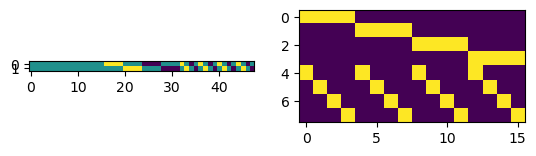

In [124]:
# Num of stim
Q = 4
thetas = [np.pi*2/Q*i for i in range(Q)]

targets = np.zeros([2, 3*Q**2])
regressors = np.zeros([2*Q, Q**2])
counter = 0
for q in range(Q):
    targets[0,Q**2+q*Q:Q**2+Q+q*Q] = np.cos(thetas[q])
    targets[1,Q**2+q*Q:Q**2+Q+q*Q] = np.sin(thetas[q])

    targets[0,2*Q**2+q:3*Q**2:Q] = np.cos(thetas[q])
    targets[1,2*Q**2+q:3*Q**2:Q] = np.sin(thetas[q])


    for qp in range(Q):
        regressors[q, counter] = 1
        regressors[qp+Q,counter] = 1
        counter+=1
    
regressors_redux = regressors
def generate_rep(A):
    return A

def generate_W(A):
    W1 = jnp.matmul(A[:,Q**2:2*Q**2], jnp.linalg.pinv(A[:,:Q**2]))
    W2 = jnp.matmul(A[:,2*Q**2:3*Q**2], jnp.linalg.pinv(A[:,:Q**2]))
    return jnp.stack([W1, W2])
    



plt.subplot(1,2,1)
plt.imshow(targets)


plt.subplot(1,2,2)
plt.imshow(regressors)

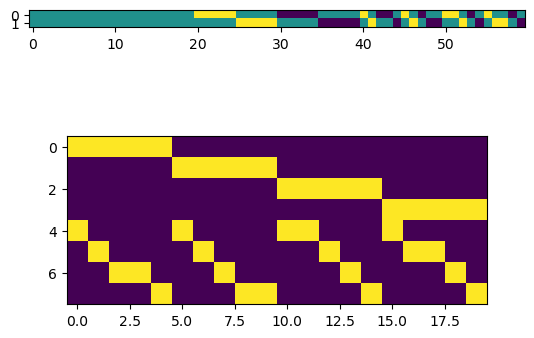

In [211]:
remove_to_bias = 0
add_correlations = 1
num_copies = 2

if remove_to_bias:
    remove_indices = []

    for trial in range(Q*Q):
        first_target = np.where(regressors[:Q, trial]==1)[0]
        second_target = np.where(regressors[Q:, trial]==1)[0]
        if first_target == second_target:# or first_target == np.mod(second_target+int(Q/2), Q):
            remove_indices.append(trial)

    remove_timepoints = remove_indices + [i + Q*Q for i in remove_indices] + [i + 2*Q*Q for i in remove_indices]

    regressors = np.delete(regressors, remove_indices, axis = 1)
    targets = np.delete(targets, remove_timepoints, axis = 1)
    num_trials = Q*Q - len(remove_indices)

    def generate_W(A):
        W1 = jnp.matmul(A[:,num_trials:2*num_trials], jnp.linalg.pinv(A[:,:num_trials]))
        W2 = jnp.matmul(A[:,2*num_trials:3*num_trials], jnp.linalg.pinv(A[:,:num_trials]))
        return jnp.stack([W1, W2])
        
    plt.subplot(1,2,1)
    plt.imshow(targets)
    
    
    plt.subplot(1,2,2)
    plt.imshow(regressors)

    line_pos = [num_trials, 2*num_trials]

elif remove_to_bias == 0 and add_correlations == 0:
    num_trials = Q*Q
    
else:
    num_trials = Q*Q+(num_copies-1)*Q

    targets = np.zeros([2, 3*num_trials])
    regressors = np.zeros([2*Q, num_trials])
    counter = 0
    for q in range(Q):
        for qp in range(Q):
            if np.mod(q - qp, Q) == 2:
                dup = num_copies
            else:
                dup = 1

            for du in range(dup):
                targets[0,counter + num_trials] = np.cos(thetas[q])
                targets[1,counter + num_trials] = np.sin(thetas[q])
            
                targets[0,counter + 2*num_trials] = np.cos(thetas[qp])
                targets[1,counter + 2*num_trials] = np.sin(thetas[qp])
            
                regressors[q, counter] = 1
                regressors[qp+Q,counter] = 1
                counter+=1

    def generate_W(A):
        W1 = jnp.matmul(A[:,num_trials:2*num_trials], jnp.linalg.pinv(A[:,:num_trials]))
        W2 = jnp.matmul(A[:,2*num_trials:3*num_trials], jnp.linalg.pinv(A[:,:num_trials]))
        return jnp.stack([W1, W2])
                
    plt.subplot(2,1,1)
    plt.imshow(targets)
    
    
    plt.subplot(2,1,2)
    plt.imshow(regressors)

line_pos = [num_trials, 2*num_trials]


In [212]:
bias = 1

if bias == 0:
    def generate_R(A, targets):
        g = generate_rep(A)
        Q = jnp.matmul(g, g.T)
        R = jnp.matmul(g, targets.T)
        P = jnp.matmul(jnp.linalg.inv(Q + 0.0001*jnp.eye(N)), R)
        return P        

    def loss_fit(A, targets):
        R = generate_R(A, targets)
        L_fit = jnp.linalg.norm(targets - jnp.matmul(R.T, generate_rep(A)))
        return L_fit   

    def generate_predictions(A, targets):
        g = generate_rep(A)
        R = generate_R(A, targets)
        return jnp.matmul(R.T, g)
    
    def loss_R(A, targets):
        R = generate_R(A, targets)
        return jnp.sum(jnp.power(R, 2))
else:
    def generate_R(A, targets):
        g = generate_rep(A)
        g_bias = jnp.vstack([g, jnp.ones(g.shape[1])[None,:]])
        Q = jnp.matmul(g_bias, g_bias.T)
        R = jnp.matmul(g_bias, targets.T)
        P = jnp.matmul(jnp.linalg.inv(Q + 0.0001*jnp.eye(N+1)), R)
        return P

    def loss_fit(A, targets):
        g = generate_rep(A)
        g_bias = jnp.vstack([g, jnp.ones(g.shape[1])[None,:]])
        R = generate_R(A, targets)
        L_fit = jnp.linalg.norm(targets - jnp.matmul(R.T, g_bias))
        return L_fit   

    def generate_predictions(A, targets):
        g = generate_rep(A)
        g_bias = jnp.vstack([g, jnp.ones(g.shape[1])[None,:]])
        R = generate_R(A, targets)
        return jnp.matmul(R.T, g_bias)

    def loss_R(A, targets):
        R = generate_R(A, targets)[:-1,:]
        return jnp.sum(jnp.power(R, 2))     

def loss_pos(A):
    g = generate_rep(A)
    g_neg = (g - jnp.abs(g))/2
    L_pos = -jnp.mean(g_neg)
    return L_pos

def loss_act(A):
    g = generate_rep(A)
    return jnp.sum(jnp.power(g, 2))

def loss_W(A):
    W = generate_W(A)
    return jnp.linalg.norm(W)**2

def loss_PI(A):
        g = generate_rep(A)
        W = generate_W(A)
        L = 0
        L += jnp.linalg.norm(jnp.matmul(W[0], g[:,:num_trials]) - g[:,num_trials:2*num_trials])
        L += jnp.linalg.norm(jnp.matmul(W[1], g[:,:num_trials]) - g[:,2*num_trials:3*num_trials])
        return L

jl_PI = jit(loss_PI)
jl_fit = jit(loss_fit)
jl_act = jit(loss_act)
jl_pos = jit(loss_pos)
jl_W = jit(loss_W)
jl_R = jit(loss_R)

In [287]:
# mu_fit = 200
mu_act = 25
mu_W = 0.25
mu_R = 0.25
mu_pos = 20000
fit_thresh = 0.01
def loss_func(A, targets):
    return  mu_fit*jnn.relu(loss_fit(A, targets)-fit_thresh) + mu_act*loss_act(A) + mu_W*loss_W(A) + mu_pos*jl_pos(A) + mu_R*loss_R(A, targets)


@jit
def update(A, targets, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss_func)(A, targets)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

random_seed = 84212198
N = 30
step_size = 1e-4

re_init = 1
if re_init:
    key = random.PRNGKey(random_seed)
    D = targets.shape[1]
    A = random.normal(key, (N,D))
    opt_init, opt_update, get_params = optimizers.adam(step_size)
    opt_state = opt_init(A)
min_loss = np.infty
print(loss_func(A, targets))


56111.953


In [288]:
T = 100000000
angle_print = 0
print_iter = 20000

for t in range(T):
    A, opt_state, loss = update(A, targets, opt_state)

    if t % print_iter == 0:
        L_f = jl_fit(A, targets)
        L_a = jl_act(A)
        L_w = jl_W(A)
        L_p = jl_pos(A)
        L_R = jl_R(A, targets)
        L_PI = jl_PI(A)
                      
        print(f"Step {t}, Loss: {loss:.5f}, Fit: {L_f:.5f}, Act: {L_a:.5f}, Wei: {L_w:.5f}, R: {L_R:.5f}, Pos: {L_p:.5f}, PI: {L_PI:.5f}")
        
        min_this_step = 0

        if angle_print == 1:
            g = generate_rep(A)
            g_delay = g[:,:num_trials]
            
            g_delay_redux = np.zeros([N, Q*Q])
            for q in range(Q):
                for qp in range(Q):
                    g_delay_redux[:,q*Q+qp] = np.mean(g_delay[:,np.logical_and(regressors[q,:] == 1, regressors[Q+qp,:] == 1)], axis = 1)
            regressors_here = regressors_redux
            g_delay = g_delay_redux
    
            PCs = np.zeros([N, 2, 2])
            for order in range(2):
                diff_vec = []
                for q in range(Q):
                    q_not_in_other_rank = np.where(regressors_here[(1-order)*Q+q,:] != 1)[0]
                    q_in_this_rank = np.where(regressors_here[Q*order+q,:] == 1)[0]
                    for qp in range(Q):
                        if qp != q:
                            qp_not_in_other_rank = np.where(regressors_here[(1-order)*4+qp,:] != 1)[0]
                            qp_in_this_rank = np.where(regressors_here[Q*order+qp,:] == 1)[0]
            
                            other_rank_not_q_or_qp = np.intersect1d(q_not_in_other_rank, qp_not_in_other_rank)
                            q_this_rank_avg_ind = np.intersect1d(q_in_this_rank, other_rank_not_q_or_qp)
                            qp_this_rank_avg_ind = np.intersect1d(qp_in_this_rank, other_rank_not_q_or_qp)
            
                            diff_vec.append(np.mean(g_delay[:,q_this_rank_avg_ind],axis=1) - np.mean(g_delay[:,qp_this_rank_avg_ind], axis = 1))
                            
                diff_vec = np.stack(diff_vec).T
                PCs[:,order,:] = get_PCs(diff_vec)
    
            U, S, V = np.linalg.svd(PCs[:,0,:].T@PCs[:,1,:])
            angles = np.arccos(S)/np.pi*180
            print(f'Angles: {angles}')

    if loss < min_loss:
        A_best = A
        min_loss = loss
        if min_this_step == 0:
            print(f'New min! {loss}')
            min_this_step = 1

Step 0, Loss: 56111.95312, Fit: 4.89736, Act: 1869.07202, Wei: 132.12503, R: 0.51312, Pos: 0.41831, PI: 0.00003
New min! 56111.953125
Step 20000, Loss: 18956.62891, Fit: 0.00981, Act: 617.59460, Wei: 140.09863, R: 47.18461, Pos: 0.17344, PI: 0.00002
New min! 18956.62890625
Step 40000, Loss: 5730.37354, Fit: 0.00940, Act: 179.01453, Wei: 144.21191, R: 104.29868, Pos: 0.05963, PI: 0.00001
New min! 5730.37353515625
Step 60000, Loss: 1399.39148, Fit: 0.00661, Act: 40.45955, Wei: 91.57681, R: 116.75523, Pos: 0.01679, PI: 0.00000
New min! 1399.3914794921875
Step 80000, Loss: 284.14456, Fit: 0.01005, Act: 6.96259, Wei: 52.11244, R: 127.53687, Pos: 0.00326, PI: 0.00000
New min! 284.1445617675781
Step 100000, Loss: 93.72291, Fit: 0.01002, Act: 1.79943, Wei: 25.71713, R: 138.90218, Pos: 0.00038, PI: 0.00000
New min! 93.72290802001953
Step 120000, Loss: 76.01234, Fit: 0.00705, Act: 1.39546, Wei: 24.64276, R: 139.46805, Pos: 0.00001, PI: 0.00000
New min! 76.01234436035156
Step 140000, Loss: 75.560

KeyboardInterrupt: 

In [289]:
print(min_loss)

75.28914


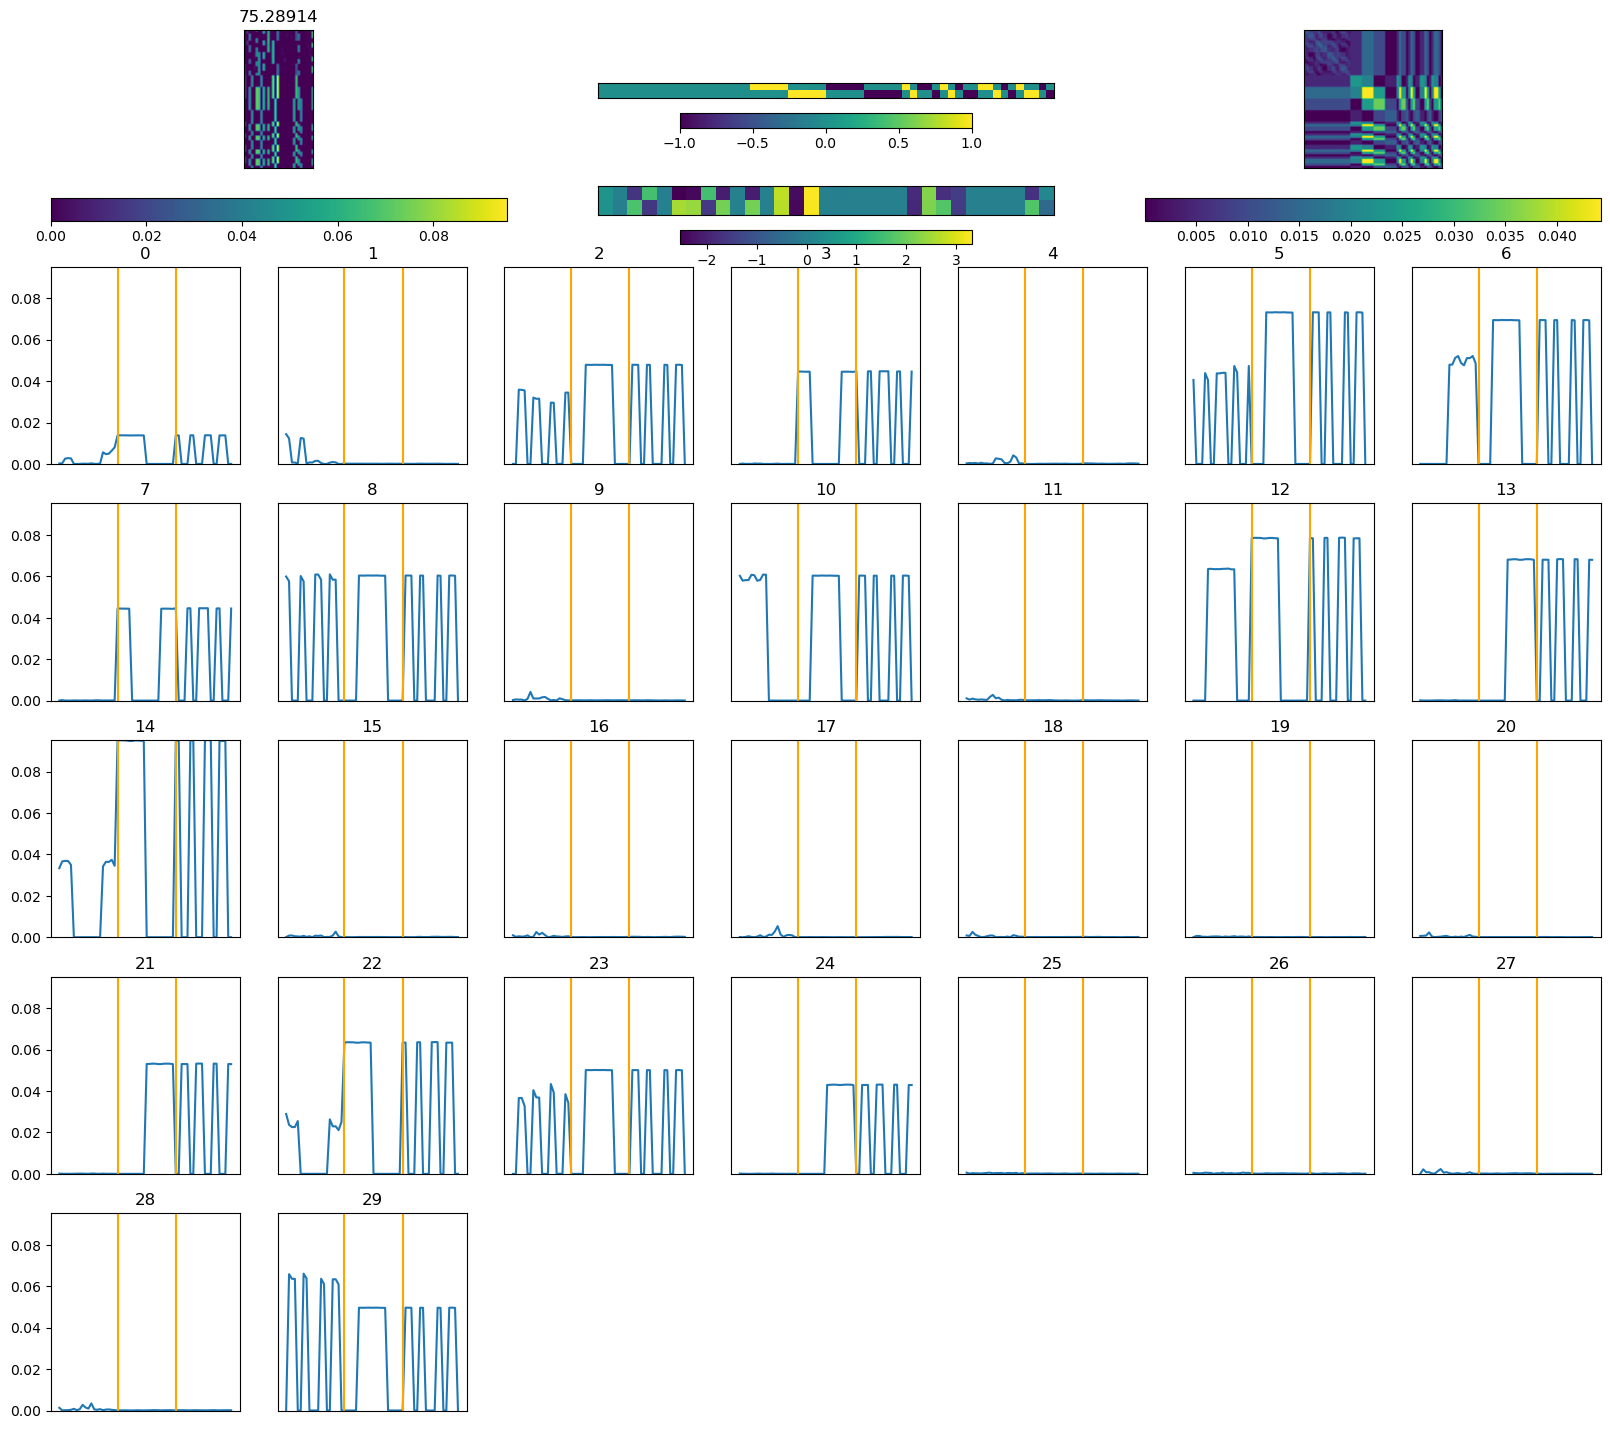

In [290]:
cols = 7
g = plot_rep(A_best, plot_col = cols, plot_row = int(np.ceil(N/cols)+2), lines = line_pos)

In [291]:
np.save('./data/P&B_Corr_2.npy', generate_rep(A_best))